<a href="https://colab.research.google.com/github/Axlbenja/MiamiDadeCounty_EmployeePay_2025/blob/main/Module_6_%E2%80%94_Axel_Paredes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xgboost shap utils
!pip install seaborn
#Imports
import pandas as pd
import statsmodels.api as sm
import shap
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance
import shap
shap.initjs()
import sys
sys.path.append('../')
import utils
import plotly.express as px
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=a610706d7f2a02b9f8d5cbb7ac498747c436fda221dbf43e4dd57d708efba177
  Stored in directory: /root/.cache/pip/wheels/15/0c/b3/674aea8c5d91c642c817d4d630bd58faa316724b136844094d
Successfully built utils


In [2]:
dataset_url = "https://raw.githubusercontent.com/fenago/datasets/refs/heads/main/heart_disease_health_indicators_BRFSS2015.csv"
df = pd.read_csv(dataset_url)
print("Dataset Loaded Successfully\n")
print(df.head())

Dataset Loaded Successfully

   HeartDiseaseorAttack  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0                   0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1                   0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2                   0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3                   0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4                   0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   Diabetes  PhysActivity  Fruits  ...  AnyHealthcare  NoDocbcCost  GenHlth  \
0       0.0           0.0     0.0  ...            1.0          0.0      5.0   
1       0.0           1.0     0.0  ...            0.0          1.0      3.0   
2       0.0           0.0     1.0  ...            1.0          1.0      5.0   
3       0.0           1.0     1.0  ...            1.0          0.0      2.0   
4       0.0           1.0     1.0  ...            1.0          0.0      2.0   

   MentHlth  PhysHlth  Diff

In [3]:
print("\nDataset Info:")
print(df.info())
print("\nUnique Values Per Column:")
print(df.nunique())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   HeartDiseaseorAttack  253680 non-null  float64
 1   HighBP                253680 non-null  float64
 2   HighChol              253680 non-null  float64
 3   CholCheck             253680 non-null  float64
 4   BMI                   253680 non-null  float64
 5   Smoker                253680 non-null  float64
 6   Stroke                253680 non-null  float64
 7   Diabetes              253680 non-null  float64
 8   PhysActivity          253680 non-null  float64
 9   Fruits                253680 non-null  float64
 10  Veggies               253680 non-null  float64
 11  HvyAlcoholConsump     253680 non-null  float64
 12  AnyHealthcare         253680 non-null  float64
 13  NoDocbcCost           253680 non-null  float64
 14  GenHlth               253680 non-null

In [4]:
df = df.drop_duplicates()

In [5]:
df = df.dropna()

In [6]:
df.to_csv("heart_disease_cleaned_data.csv", index=False)
print("\nCleaned dataset saved as heart_disease_cleaned_data.csv")


Cleaned dataset saved as heart_disease_cleaned_data.csv


In [7]:
secondary_data = {
    "HeartDiseaseorAttack": [0, 1],
    "Average_BP": [120, 140],
    "Cholesterol_Level": [200, 250]
}
secondary_df = pd.DataFrame(secondary_data)

In [8]:
merged_df = df.merge(secondary_df, on="HeartDiseaseorAttack", how="left")

In [9]:
merged_df.to_csv("heart_disease_merged_data.csv", index=False)
print("\nMerged dataset saved as heart_disease_merged_data.csv")


Merged dataset saved as heart_disease_merged_data.csv


#Data Binning

In [10]:
df = pd.read_csv("heart_disease_cleaned_data.csv")

In [11]:
#Bin the BMI column
bins = [0, 18.5, 25, 30, float('inf')]  # Underweight (<18.5), Normal (18.5-24.9), Overweight (25-29.9), Obese (>=30)
labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
df['BMI_Category'] = pd.cut(df['BMI'], bins=bins, labels=labels, include_lowest=True)

In [12]:
print(df['BMI_Category'].value_counts())

BMI_Category
Overweight     81555
Normal         73736
Obese          71437
Underweight     3053
Name: count, dtype: int64


In [13]:
df.to_csv("heart_disease_binned_data.csv", index=False)
print("Dataset with binned BMI saved as 'heart_disease_binned_data.csv'")

Dataset with binned BMI saved as 'heart_disease_binned_data.csv'


#Lambda Function Application

In [15]:
df = pd.read_csv("heart_disease_binned_data.csv")

In [16]:
df['Health_Risk_Score'] = df.apply(lambda row: (row['BMI'] * 0.3) + (row['HighBP'] * 10) + (row['Smoker'] * 15), axis=1)

In [17]:
print(df[['BMI', 'HighBP', 'Smoker', 'Health_Risk_Score']].head())

    BMI  HighBP  Smoker  Health_Risk_Score
0  40.0     1.0     1.0               37.0
1  25.0     0.0     1.0               22.5
2  28.0     1.0     0.0               18.4
3  27.0     1.0     0.0               18.1
4  24.0     1.0     0.0               17.2


In [18]:
df.to_csv("heart_disease_lambda_data.csv", index=False)
print("Dataset with lambda function output saved as 'heart_disease_lambda_data.csv'")

Dataset with lambda function output saved as 'heart_disease_lambda_data.csv'


#Feature Engineering

In [19]:
#Lambda dataset
df = pd.read_csv("heart_disease_lambda_data.csv")

In [21]:
df['Physical_Activity_Level'] = df.apply(lambda row:
    'High' if (row['PhysActivity'] == 1 and row['DiffWalk'] == 0) else
    'Moderate' if (row['PhysActivity'] == 1 and row['DiffWalk'] == 1) else
    'Low' if (row['PhysActivity'] == 0 and row['DiffWalk'] == 0) else
    'None', axis=1)

In [22]:
print(df['Physical_Activity_Level'].value_counts())

Physical_Activity_Level
High        146570
Low          40585
Moderate     21941
None         20685
Name: count, dtype: int64


In [23]:
df.to_csv("heart_disease_feature_engineered_data.csv", index=False)
print("Dataset with new feature saved as 'heart_disease_feature_engineered_data.csv'")

Dataset with new feature saved as 'heart_disease_feature_engineered_data.csv'


#Deep Exploratory Data Analysis

In [34]:
df = pd.read_csv("heart_disease_feature_engineered_data.csv")

In [31]:
print(df.columns)

Index(['HeartDiseaseorAttack', 'HighBP', 'HighChol', 'CholCheck', 'BMI',
       'Smoker', 'Stroke', 'Diabetes', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education', 'Income',
       'BMI_Category', 'Health_Risk_Score', 'Physical_Activity_Level'],
      dtype='object')


In [35]:
print("NaN values in BMI_Category:", df['BMI_Category'].isna().sum())
print("NaN values in HeartDiseaseorAttack:", df['HeartDiseaseorAttack'].isna().sum())
print("Unique values in BMI_Category:", df['BMI_Category'].unique())
print("Unique values in HeartDiseaseorAttack:", df['HeartDiseaseorAttack'].unique())

NaN values in BMI_Category: 0
NaN values in HeartDiseaseorAttack: 0
Unique values in BMI_Category: ['Obese' 'Normal' 'Overweight' 'Underweight']
Unique values in HeartDiseaseorAttack: [0. 1.]


In [36]:
df['BMI_Category'] = df['BMI_Category'].fillna('Unknown')
df['HeartDiseaseorAttack'] = df['HeartDiseaseorAttack'].fillna(0)

In [37]:
df = df.rename(columns={'HeartDiseaseorAttack': 'HeartDisease'})

#Distribution of Heart Disease by BMI Category

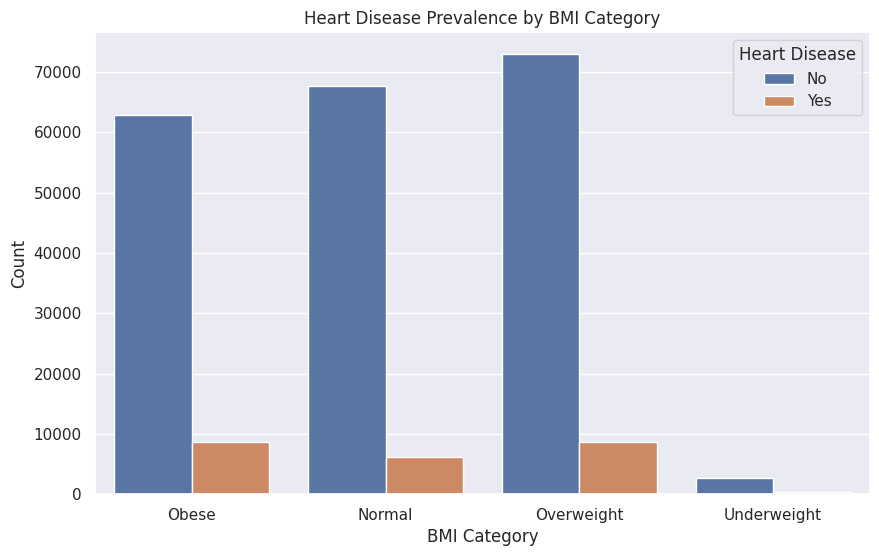

In [38]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='BMI_Category', hue='HeartDisease')
plt.title('Heart Disease Prevalence by BMI Category')
plt.xlabel('BMI Category')
plt.ylabel('Count')
plt.legend(title='Heart Disease', labels=['No', 'Yes'])
plt.show()

#Heart Disease vs. Health Risk Score (Boxplot)

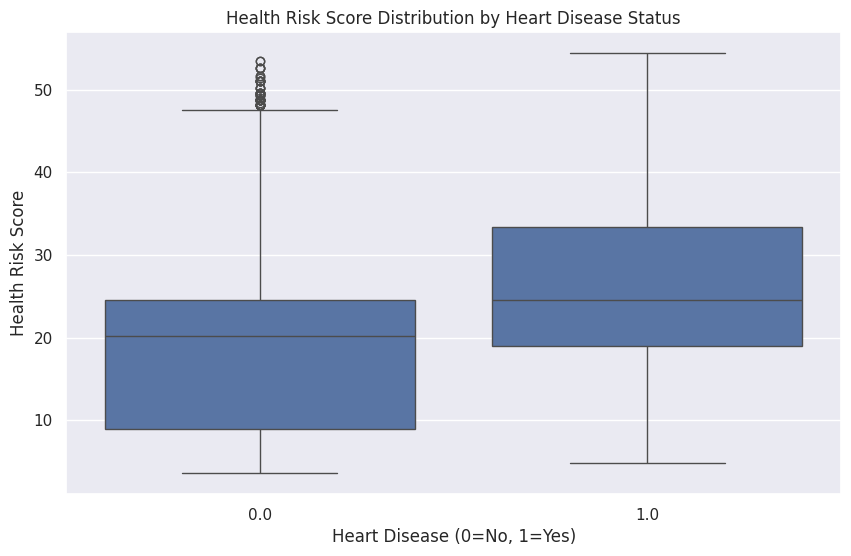

In [39]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='HeartDisease', y='Health_Risk_Score')
plt.title('Health Risk Score Distribution by Heart Disease Status')
plt.xlabel('Heart Disease (0=No, 1=Yes)')
plt.ylabel('Health Risk Score')
plt.show()

#Heart Disease by Physical Activity Level

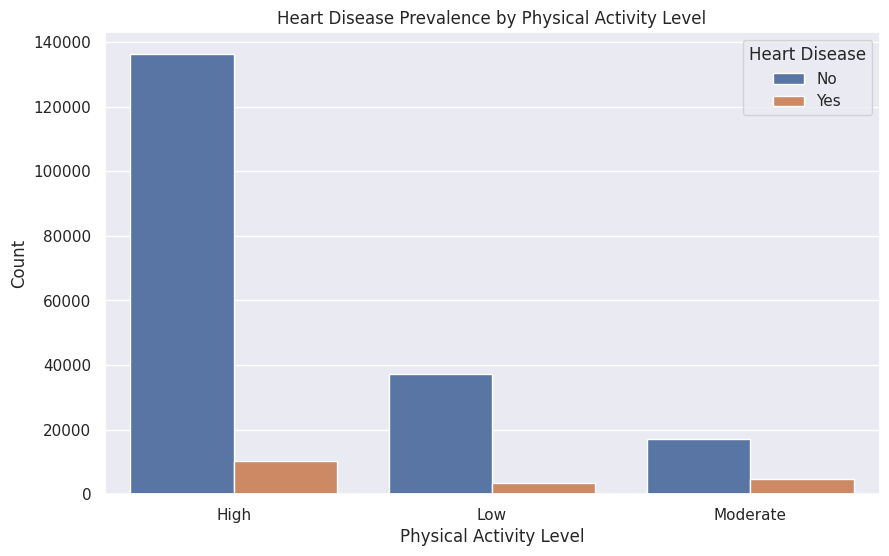

In [40]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Physical_Activity_Level', hue='HeartDisease')
plt.title('Heart Disease Prevalence by Physical Activity Level')
plt.xlabel('Physical Activity Level')
plt.ylabel('Count')
plt.legend(title='Heart Disease', labels=['No', 'Yes'])
plt.show()

#Correlation Heatmap of Numeric Variables

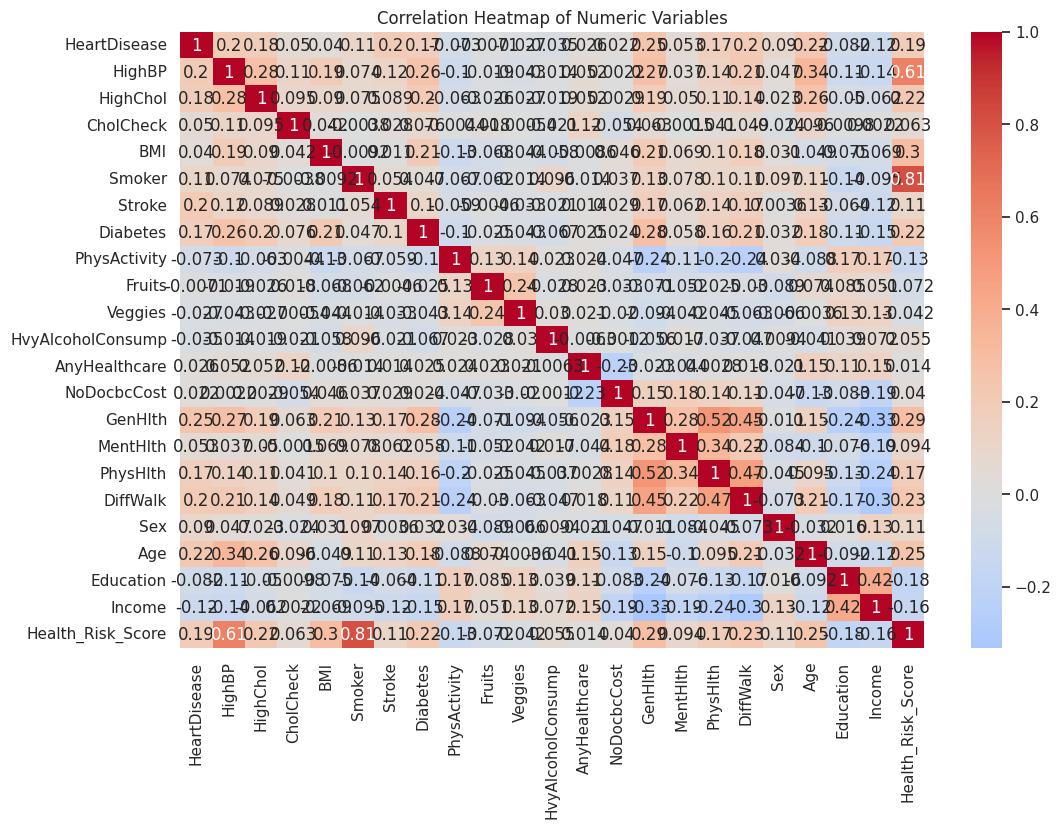

In [41]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Numeric Variables')
plt.show()

#Age Distribution by Heart Disease

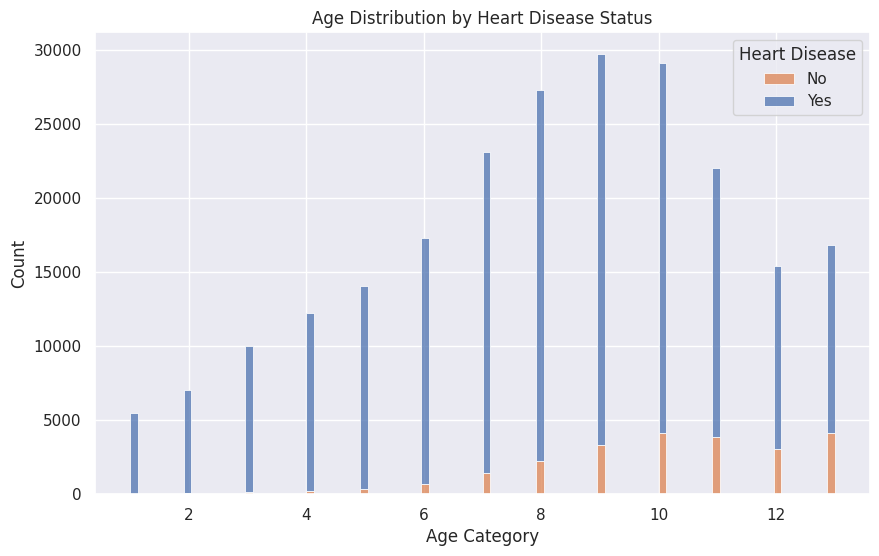

In [42]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Age', hue='HeartDisease', multiple='stack', palette='deep')
plt.title('Age Distribution by Heart Disease Status')
plt.xlabel('Age Category')
plt.ylabel('Count')
plt.legend(title='Heart Disease', labels=['No', 'Yes'])
plt.show()